# Training Masker

Nama : Djarot Hindarto
    
NIM : 2020101006

In [83]:

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# ------------ Input gambar ----------------------
args = {'dataset': 'dataset', 'plot': 'plot.png', 'model': 'Maskerdetect.model'}


# initialize the initial learning rate
INIT_LR = 1e-4
# number of epochs to train 
EPOCHS = 20
# and batch size
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
imagePaths = list(paths.list_images(args["dataset"]))

data = []
labels = []

imagePaths

['dataset/with_mask/augmented_image_218.jpg',
 'dataset/with_mask/augmented_image_19.jpg',
 'dataset/with_mask/augmented_image_31.jpg',
 'dataset/with_mask/augmented_image_25.jpg',
 'dataset/with_mask/augmented_image_230.jpg',
 'dataset/with_mask/419-with-mask.jpg',
 'dataset/with_mask/330-with-mask.jpg',
 'dataset/with_mask/260-with-mask.jpg',
 'dataset/with_mask/27-with-mask.jpg',
 'dataset/with_mask/327-with-mask.jpg',
 'dataset/with_mask/277-with-mask.jpg',
 'dataset/with_mask/30-with-mask.jpg',
 'dataset/with_mask/13-00.jpg',
 'dataset/with_mask/13-14.jpg',
 'dataset/with_mask/augmented_image_3.jpg',
 'dataset/with_mask/augmented_image_152.jpg',
 'dataset/with_mask/augmented_image_146.jpg',
 'dataset/with_mask/11-05.jpg',
 'dataset/with_mask/11-11.jpg',
 'dataset/with_mask/309-with-mask.jpg',
 'dataset/with_mask/259-with-mask.jpg',
 'dataset/with_mask/420-with-mask.jpg',
 'dataset/with_mask/augmented_image_191.jpg',
 'dataset/with_mask/155-with-mask.jpg',
 'dataset/with_mask/augme

In [84]:

print("Total file picture          : ", len(imagePaths))

import os

dirmask = "/Users/djarothindarto/FundamentalDS/Masker/dataset/with_mask"
dirtanpa = "/Users/djarothindarto/FundamentalDS/Masker/dataset/without_mask"
path, dirs, files = next(os.walk(dirmask))
file_count = len(files)
print("File picture with masker    : ",file_count)

path, dirs, files = next(os.walk(dirtanpa))
file_count = len(files)
print("File picture without masker : ",file_count)

Total file picture          :  1578
File picture with masker    :  787
File picture without masker :  791


In [85]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

print(data)


[[[[ 0.7647059   0.6         0.18431377]
   [ 0.67058825  0.54509807  0.13725495]
   [ 0.8745098   0.79607844  0.39607847]
   ...
   [ 0.73333335  0.6627451   0.5294118 ]
   [ 0.8980392   0.81960785  0.7411765 ]
   [-0.46666664 -0.5686275  -0.6392157 ]]

  [[ 0.62352943  0.45882356  0.12156868]
   [ 0.7254902   0.5764706   0.24705887]
   [ 0.8666667   0.7176471   0.4039216 ]
   ...
   [ 0.5686275   0.49803925  0.27058828]
   [ 0.8901961   0.8901961   0.6862745 ]
   [-0.5686275  -0.5058824  -0.67058825]]

  [[ 0.6627451   0.52156866  0.20784318]
   [ 0.7254902   0.5529412   0.24705887]
   [ 0.8980392   0.67058825  0.4039216 ]
   ...
   [ 0.827451    0.75686276  0.43529415]
   [ 0.62352943  0.6627451   0.34901965]
   [-0.6862745  -0.5686275  -0.79607844]]

  ...

  [[-0.8901961  -0.8117647  -1.        ]
   [-0.9607843  -0.92941177 -1.        ]
   [-0.58431375 -0.5686275  -0.654902  ]
   ...
   [ 0.94509804  0.58431375  0.6       ]
   [ 0.85882354  0.64705884  0.5137255 ]
   [-0.41176468 

In [68]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [69]:
# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor = Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# looping for all layers in model and not updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[Processing model with Optimation Adam")
opt = Adam(lr=INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


# train the head of the network
print("Processing Training head.")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

# make predictions on the testing set
print("Evaluating nural network.")
predIdxs = model.predict(testX, batch_size = BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# serialize the model to disk
print("Saving Masker detection model.")
model.save(args["model"], save_format="h5")

[INFO] compiling model Optimasi Adam
[INFO] training head...
Epoch 1/20
39/39 [==============================] - 58s 1s/step - loss: 0.7599 - accuracy: 0.5857 - val_loss: 0.3288 - val_accuracy: 0.9272
Epoch 2/20
39/39 [==============================] - 82s 2s/step - loss: 0.3559 - accuracy: 0.8736 - val_loss: 0.2066 - val_accuracy: 0.9430
Epoch 3/20
39/39 [==============================] - 78s 2s/step - loss: 0.2522 - accuracy: 0.9323 - val_loss: 0.1602 - val_accuracy: 0.9430
Epoch 4/20
39/39 [==============================] - 63s 2s/step - loss: 0.2029 - accuracy: 0.9208 - val_loss: 0.1370 - val_accuracy: 0.9462
Epoch 5/20
39/39 [==============================] - 58s 1s/step - loss: 0.1656 - accuracy: 0.9438 - val_loss: 0.1200 - val_accuracy: 0.9494
Epoch 6/20
39/39 [==============================] - 55s 1s/step - loss: 0.1413 - accuracy: 0.9473 - val_loss: 0.1116 - val_accuracy: 0.9462
Epoch 7/20
39/39 [==============================] - 59s 1s/step - loss: 0.1497 - accuracy: 0.9336 -

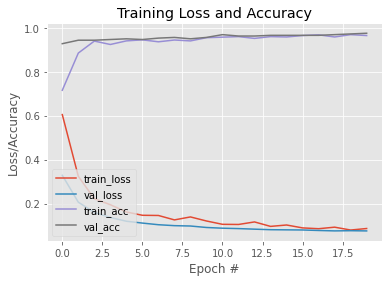

In [70]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])